## TextRank

TextRank is an unsupervised algorithm used for automatic text summarization and keyword extraction. It works by representing text as a graph, where sentences or words are nodes connected by weighted edges. The algorithm calculates the importance of each node (sentence) based on the number and strength of its connections, similar to Google's PageRank algorithm. TextRank assigns higher scores to nodes that have more inbound connections from important nodes, indicating their significance in the text. The top-ranked sentences or words are then selected as the summary or keywords, respectively, providing a concise representation of the original text.

<center><img src = "markdown_files/text_rank.png"></center>

[Reference Link](https://www.analyticsvidhya.com/blog/2018/11/introduction-text-summarization-textrank-python/)

In [564]:
import contractions
import string
import re
import math

import pandas as pd
import matplotlib.pyplot as plt

from datasets import load_dataset

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize

import networkx as nx
from rouge import Rouge

from sklearn.metrics.pairwise import cosine_similarity
from sklearn.feature_extraction.text import TfidfVectorizer

In [565]:
dataset = load_dataset('cnn_dailymail', '3.0.0')
data = dataset['test']
data_df = pd.DataFrame(data)

Found cached dataset cnn_dailymail (C:/Users/vijay/.cache/huggingface/datasets/cnn_dailymail/3.0.0/3.0.0/1b3c71476f6d152c31c1730e83ccb08bcf23e348233f4fcc11e182248e6bf7de)


  0%|          | 0/3 [00:00<?, ?it/s]

In [566]:
nltk.download('wordnet')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\vijay\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


### Text preprocessing

#### Preprocessing steps:
<ol>
<li>convert all characters in the text to lowercase</li>

**Example**: if the input text is "Hello World", it will be converted to "hello world".

<li>Tokenize the article into sentences using sent_tokenize function from the NLTK library.</li>

**Example**: if the input text is "Hello! How are you? I hope you're doing well. Have a great day!", it will be tokenized into the list of sentences ['Hello!', 'How are you?', "I hope you're doing well.", 'Have a great day!']

For each of the sentences perform the following preprocessing steps :
<ol>
<li>Remove all punctuation marks from the text using the translate method and maketrans function from the string module.</li>

**Example**: if the input text is "Hello, World!", it will be converted to "Hello World".

<li>Remove any non-alphanumeric characters from the text using regular expressions. It replaces any character that is not a word character (\w) or whitespace character (\s) with an empty string.</li> 

**Example**: if the input text is "Hello @world!", it will be converted to "Hello World".

<li>Expand contracted words in the text using the contractions library.</li>

**Example**: if the input preprocessed text is "I'm happy", it will be expanded to "I am happy".

<li>Tokenize the preprocessed text into individual words using the word_tokenize function from the NLTK library.</li> 

**Example**: if the input text is "Hello World", it will be tokenized into the list of tokens: ['Hello', 'World'].

<li>Remove stop words from the list of tokens. Stop words are commonly occurring words (e.g., "the", "is", "and") that do not carry much meaning in the context of natural language processing tasks.</li>

**Example**: if the input tokens are ['Hello', 'World', 'this', 'is', 'a'], and the stop words list contains ['this', 'is', 'a'], the resulting tokens will be ['Hello', 'World'].

</ol>
</ol>

In [567]:
def preprocess_text(text):
    """
    Preprocesses the input text by performing several text cleaning steps.
    
    Args:
        text (str): The input text to be preprocessed.
        
    Returns:
        tuple: A tuple containing two elements:
            - preprocessed_sentences (list): A list of preprocessed sentences, where each sentence is tokenized.
            - sentences (list): A list of original sentences (not preprocessed).
    """
    # Convert the text to lowercase.
    text = text.lower()
    
    # Tokenize the text into sentences.
    sentences = sent_tokenize(text)
    stop_words = set(stopwords.words('english'))
    preprocessed_sentences = []
    
    for sentence in sentences:
        
        # Remove punctuation from each sentence.
        sentence = sentence.translate(str.maketrans("", "", string.punctuation))
        
        # Remove non-alphanumeric characters
        sentence = re.sub(r"[^\w\s]", "", sentence)
        
        # Expand contractions
        sentence = contractions.fix(sentence)
        
        # Tokenize the sentence into individual words
        tokens = word_tokenize(sentence)
        
        # Remove stop words
        tokens = [token for token in tokens if token not in stop_words]
        
        preprocessed_sentences.append(tokens)
    
    return preprocessed_sentences, sentences

### Apply pre-processing steps and Tokenize sentences in an article

In [568]:
data_df['processed_article', 'sentence_tokens'] = data_df['article'].apply(preprocess_text)

In [569]:
data_df['processed_article'] = data_df['processed_article', 'sentence_tokens'].apply(lambda x:x[0])
data_df['sentence_tokens'] = data_df['processed_article', 'sentence_tokens'].apply(lambda x:x[1])

### Build Similarity Matrix

- The function plays a key role in text summarization using the TextRank algorithm. 
- It takes a list of sentences as input and constructs a similarity matrix. First, it converts each sentence into a numerical representation called a sentence vector. 
- Then, it applies the TF-IDF transformation to these vectors, which assigns weights to words based on their frequency and rarity across the document. This step helps capture the importance of words within each sentence. 
- Finally, it calculates the cosine similarity between all pairs of sentences using the TF-IDF vectors. The resulting similarity matrix provides a measure of how similar or related each sentence is to the others.
- By comparing the sentences based on their TF-IDF representations, the algorithm can determine the most central and representative sentences in the text.

**Example**:
Let's consider three sentences:

"I love to play soccer."<br>
"Soccer is my favorite sport."<br>
"I enjoy watching soccer matches."<br>

- The first step is to convert each sentence into a numerical representation called a sentence vector

Sentence 1 vector: [1, 1, 0, 0, 1, 0]<br>
Sentence 2 vector: [1, 1, 1, 1, 0, 1]<br>
Sentence 3 vector: [1, 0, 1, 0, 1, 1]<br>

- Apply the TF-IDF transformation to the sentence vectors.

$$TF-IDF = \lgroup\frac {\text{Term Frequency}}  {\text{Total terms in sentence}}\rgroup * log\lgroup\frac{\text{Total sentences}} {\text{Number of sentences containing the word}}\rgroup$$


Sentence 1 TF-IDF vector: [0.25, 0.25, 0, 0, 0.405, 0]<br>
Sentence 2 TF-IDF vector: [0.25, 0.25, 0.405, 0.405, 0, 0.405]<br>
Sentence 3 TF-IDF vector: [0.25, 0, 0.405, 0, 0.405, 0.405]<br>

- Calculate the similarity between pairs of sentences using the cosine similarity formula:

$$Similarity(A, B) = (A • B) / (||A|| * ||B||)$$

<center>

|           | Sentence 1 | Sentence 2 | Sentence 3 |
|-----------|:----------:|:----------:|:----------:|
| Sentence 1 |   1.000    |   0.670    |   0.354    |
| Sentence 2 |   0.670    |   1.000    |   0.537    |
| Sentence 3 |   0.354    |   0.537    |   1.000    |

</center>

The similarity matrix shows the pairwise similarity scores between the sentences. Each element in the matrix represents the similarity between the corresponding pair of sentences. Higher values indicate greater similarity.


In [570]:
def build_similarity_matrix(sentences):
    sentence_vectors = []
    
    for sentence in sentences:
        sentence_vectors.append(' '.join(sentence))
    
    vectorizer = TfidfVectorizer().fit_transform(sentence_vectors)
    similarity_matrix = cosine_similarity(vectorizer)
    
    return similarity_matrix

In [571]:
data_df['similarity_matrix'] =  data_df['processed_article'].apply(build_similarity_matrix)

### Calculate number of sentences to retain

In [572]:
data_df['num_retain_sentence'] = data_df['processed_article'].apply(lambda x: math.ceil(len(x)/10))

### Calculate most important sentences to form a summary

The function summarizes a piece of text using a technique called TextRank. 
- It works by analyzing the relationships between sentences and assigning importance scores to each sentence based on its connections within the text.
- First, a similarity matrix is created, which represents how similar each pair of sentences is. 
- Then, a graph is constructed using the similarity matrix, where sentences are represented as nodes and their similarities as edges. 
- The importance of each sentence is determined using the PageRank algorithm, which considers the connections and centrality of each sentence in the graph.
- The sentences are ranked based on their importance scores, and the top-ranked sentences are selected to form the summary.

**Example**: 

A graph is constructed from the similarity matrix
- Graph: 
    - Node 1 (Sentence 1) -> Node 2 (Sentence 2) with edge weight 0.670
    - Node 1 (Sentence 1) -> Node 3 (Sentence 3) with edge weight 0.354
    - Node 2 (Sentence 2) -> Node 3 (Sentence 3) with edge weight 0.537


The PageRank algorithm is applied to the graph to calculate the importance scores of each sentence.

$$Score(V) = (1 - d) + d * \left(\frac{{Score(T1)}}{{C(T1)}} + \frac{{Score(T2)}}{{C(T2)}} + \ldots + \frac{{Score(Tn)}}{{C(Tn)}}\right)$$

where:
- Score(V): Represents the score of a particular vertex (sentence in this case).
- d: Refers to the damping factor, typically set to 0.85.
- T1, T2, ..., Tn: Denote the vertices (sentences) that have edges pointing to the vertex V.
- C(T1), C(T2), ..., C(Tn): Represent the out-degree of the vertices T1, T2, ..., Tn.

The sentence scores are initialized to 1. Then, the scores are updated iteratively until they converge. This is done by calculating the new score for each sentence using the PageRank formula and updating the scores accordingly. After convergence, the final scores are obtained:

Sentence 1 score: 0.447<br>
Sentence 2 score: 0.322<br>
Sentence 3 score: 0.231<br>

These scores reflect the importance of each sentence in the text.

Finally, the sentences are ranked based on their importance scores. The top n sentences with the highest scores are selected to form the summary.

let's assume we want to retain 2 sentences:

Ranked sentences: Sentence 1, Sentence 2, Sentence 3<br>
**Summary**:<br> "I love to play soccer. Soccer is my favorite sport."

In [573]:
def get_summary(row):
    
    sentence_tokens = row['sentence_tokens']
    
    similarity_matrix = row['similarity_matrix']
    top_n=row['num_retain_sentence']
    graph = nx.from_numpy_array(similarity_matrix)
    
    scores = nx.pagerank(graph)
    ranked_sentences = sorted(((scores[i], s) for i, s in enumerate(sentence_tokens)), reverse=True)
    
    sentence_array = [sentence[1] for sentence in ranked_sentences[:top_n]]
    
    return ''.join([''.join(sentence) for sentence in sentence_array])


#### Apply summarization

In [574]:
data_df['summary'] = data_df.apply(lambda row: get_summary(row), axis=1)

### Calculate ROUGE Scores

The **ROUGE** (Recall-Oriented Understudy for Gisting Evaluation) scores represent the evaluation metrics for summarization. ROUGE measures the similarity between the generated summary (system summary) and the reference summary (ground truth summary) in terms of overlapping n-grams.

The scores are reported as follows:

**ROUGE-1**: This metric focuses on the overlap of unigram (single word) sequences between the system summary and the reference summary. It measures the recall (r), precision (p), and F1 score (f) for unigrams.

**ROUGE-2**: This metric considers the overlap of bigram (two-word) sequences between the system summary and the reference summary. It measures the recall, precision, and F1 score for bigrams.

**ROUGE-L**: This metric calculates the longest common subsequence (LCS) between the system summary and the reference summary. It measures the recall, precision, and F1 score based on the LCS.


- **Precision**: Precision measures the accuracy or correctness of the generated summary. It is the ratio of the number of correctly identified relevant elements (such as words or n-grams) in the generated summary to the total number of identified elements. A higher precision indicates a lower rate of false positives.

- **Recall**: Recall measures the comprehensiveness or completeness of the generated summary. It is the ratio of the number of correctly identified relevant elements in the generated summary to the total number of relevant elements present in the reference summary. A higher recall indicates a lower rate of false negatives.

- **F1 score**: The F1 score is the harmonic mean of precision and recall. It provides a balanced measure that considers both precision and recall. The F1 score is calculated using the formula: F1 = 2 * (precision * recall) / (precision + recall). It ranges from 0 to 1, where a higher F1 score indicates a better balance between precision and recall.

In [575]:
rouge = Rouge()

data_df['rouge_scores'] = data_df.apply(lambda row: rouge.get_scores(row['summary'], row['highlights']), axis=1)

#### Calculate Average Recall, Precision, and F1 score for Rouge-1, Rouge-2 and Rouge-L

In [576]:
rouge_scores = data_df['rouge_scores']

rouge_1 = {'r': 0, 'p': 0, 'f': 0}
rouge_2 = {'r': 0, 'p': 0, 'f': 0}
rouge_l = {'r': 0, 'p': 0, 'f': 0}

for scores in rouge_scores:
    rouge_1_scores = scores[0]['rouge-1']
    rouge_2_scores = scores[0]['rouge-2']
    rouge_l_scores = scores[0]['rouge-l']

    rouge_1['r'] += rouge_1_scores['r']
    rouge_1['p'] += rouge_1_scores['p']
    rouge_1['f'] += rouge_1_scores['f']

    rouge_2['r'] += rouge_2_scores['r']
    rouge_2['p'] += rouge_2_scores['p']
    rouge_2['f'] += rouge_2_scores['f']

    rouge_l['r'] += rouge_l_scores['r']
    rouge_l['p'] += rouge_l_scores['p']
    rouge_l['f'] += rouge_l_scores['f']

num_rows = len(rouge_scores)

rouge_1_avg = {'recall': rouge_1['r'] / num_rows, 'precision': rouge_1['p'] / num_rows, 'f1-score': rouge_1['f'] / num_rows}
rouge_2_avg = {'recall': rouge_2['r'] / num_rows, 'precision': rouge_2['p'] / num_rows, 'f1-score': rouge_2['f'] / num_rows}
rouge_l_avg = {'recall': rouge_l['r'] / num_rows, 'precision': rouge_l['p'] / num_rows, 'f1-score': rouge_l['f'] / num_rows}

average_scores = pd.DataFrame({'ROUGE-1': rouge_1_avg, 'ROUGE-2': rouge_2_avg, 'ROUGE-L': rouge_l_avg})

average_scores

,ROUGE-1,ROUGE-2,ROUGE-L
recall,0.308735,0.102407,0.284861
precision,0.234754,0.072806,0.216755
f1-score,0.251790,0.078841,0.232322


#### Barplot for ROUGE scores

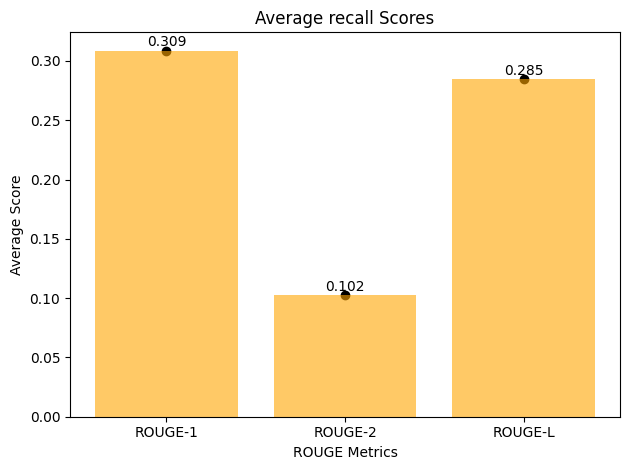

In [577]:
x_values = average_scores.columns
y_values = average_scores.loc['recall']

fig, ax1 = plt.subplots()

ax1.scatter(x_values, y_values, marker='o', color='black')
ax1.set_ylabel('Average Score')
ax1.set_xlabel('ROUGE Metrics')
ax1.set_title('Average recall Scores')

ax1.bar(x_values, y_values, color='orange', alpha=0.6)

for i, v in enumerate(y_values):
    ax1.text(i, v + 0.001, f'{v:.3f}', ha='center', va='bottom', color='black')

plt.tight_layout()

plt.show()

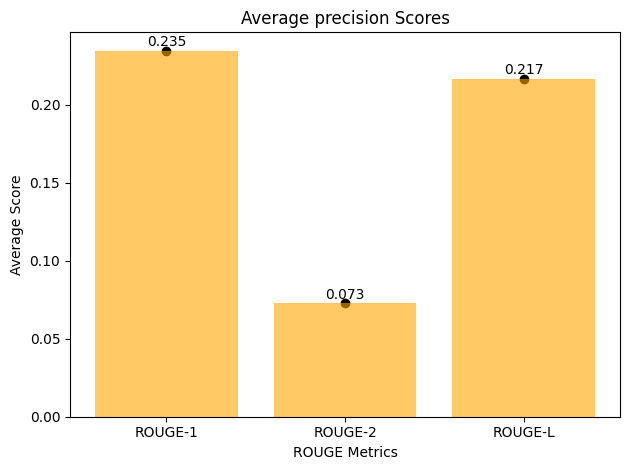

In [578]:
x_values = average_scores.columns
y_values = average_scores.loc['precision']

fig, ax1 = plt.subplots()

ax1.scatter(x_values, y_values, marker='o', color='black')
ax1.set_ylabel('Average Score')
ax1.set_xlabel('ROUGE Metrics')
ax1.set_title('Average precision Scores')

ax1.bar(x_values, y_values, color='orange', alpha=0.6)

for i, v in enumerate(y_values):
    ax1.text(i, v + 0.001, f'{v:.3f}', ha='center', va='bottom', color='black')

plt.tight_layout()

plt.show()

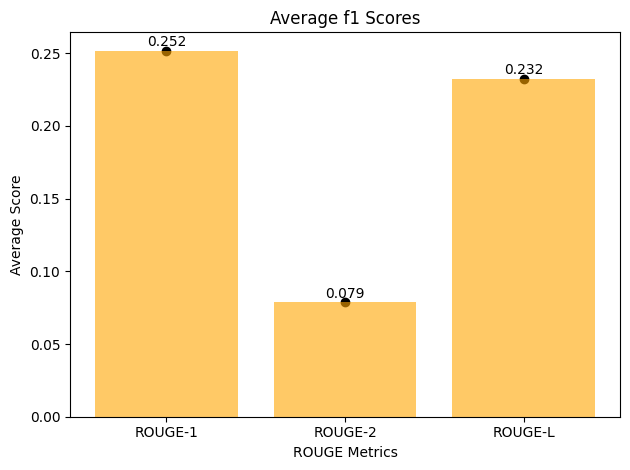

In [579]:
x_values = average_scores.columns
y_values = average_scores.loc['f1-score']

fig, ax1 = plt.subplots()

ax1.scatter(x_values, y_values, marker='o', color='black')
ax1.set_ylabel('Average Score')
ax1.set_xlabel('ROUGE Metrics')
ax1.set_title('Average f1 Scores')

ax1.bar(x_values, y_values, color='orange', alpha=0.6)

for i, v in enumerate(y_values):
    ax1.text(i, v + 0.001, f'{v:.3f}', ha='center', va='bottom', color='black')

plt.tight_layout()

plt.show()

#### Plot Heatmap for ROUGE scores

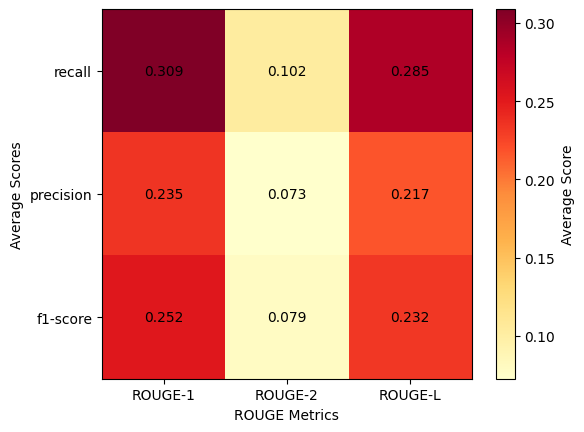

In [580]:
plt.imshow(average_scores, cmap='YlOrRd')

plt.xticks(range(len(average_scores.columns)), average_scores.columns)
plt.yticks(range(len(average_scores.index)), average_scores.index)
plt.xlabel('ROUGE Metrics')
plt.ylabel('Average Scores')

for i in range(len(average_scores.index)):
    for j in range(len(average_scores.columns)):
        plt.text(j, i, f'{average_scores.iloc[i, j]:.3f}', ha='center', va='center', color='black')

plt.colorbar(label='Average Score')

plt.show()